In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts

import requests
import json
import time

USE_SIMULATION = True

In [2]:
tf.compat.v1.enable_v2_behavior()


In [3]:
tf.version.VERSION


'2.2.0'

In [4]:
num_iterations = 200000 # @param {type:"integer"}

initial_collect_steps = 10  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 16  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


In [5]:
def observe_kettle():
    # TODO remove the offset!!
    resp = requests.get("http://192.168.178.87/")
    a = json.loads(resp.text)
    temperatures = [x[1]-50.0 for x in json.loads(resp.text)["temp"]]
    on_off = [float(x[1]) for x in json.loads(resp.text)["state"]]
    return temperatures+on_off

def turn_kettle_on():    
    resp = requests.get("http://192.168.178.87/r_on")
    
def turn_kettle_off():    
    resp = requests.get("http://192.168.178.87/r_off")

    
# observation = observe_kettle()
# print(observation)

In [6]:


class KettleEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(20,), dtype=np.float32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    # TODO print something for me to clean out the kettle...
    self._state = observe_kettle()
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):
    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 1:
        turn_kettle_on()
    elif action == 0:
        turn_kettle_off()
    else:
      raise ValueError('`action` should be 0 or 1.')

    # TODO do I have to sleep here or somewhere else...
    time.sleep(1.0)
    
    self._state = observe_kettle()

    current_temp = self._state[9]
    print("Current temp", current_temp)
    given_reward = 0.0
    if current_temp < 0:
        given_reward = 1.0-0.0*abs(current_temp)
    else:
        given_reward = 1.0-0.03*abs(current_temp)
    
    return ts.transition(np.array(self._state, dtype=np.float32), reward=given_reward, discount=1.0)



class SimulatedKettleEnv(py_environment.PyEnvironment):
  def __init__(self):    
    self.action_history_seconds = 100
    self.set_temperature = 50.0
        
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(2*self.action_history_seconds,), dtype=np.float32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False



  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    print("Resetting the kettle")
    # Reset the model of the rod and the water
    self.temperature_rod = 20.0
    self.temperature_water = 20.0
    
    # Reset the parameters which determine the state
    self.water_history = [self.temperature_water]*self.action_history_seconds
    self.action_history = [0.0]*self.action_history_seconds # pretend we did not do anything for a while
    
#     self._state = self.water_history[-self.action_history_seconds:] + self.action_history[-self.action_history_seconds:]
    self._state = [0.01*(x-self.set_temperature) for x in self.water_history[-self.action_history_seconds:]] + self.action_history[-self.action_history_seconds:]
    
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):
    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start a new episode.
      return self.reset()

    # TODO implement a better mathematical model, such as this one: https://www.ijesm.co.in/uploads/68/5720_pdf.pdf
    if action == 1:
        self.temperature_rod += 0.9
    elif action == 0:
        # don't do anything, rod will cool down anyways
        pass
    else:
      raise ValueError('`action` should be 0 or 1.')

    
    # Model the heat dissipation to the environment
    diff_temp = self.temperature_rod-self.temperature_water
    
    # I guess the rod holds quite a lot of energy and we have a small water basin (a.k.a. my setup at home)
    # would be great to infer these parameters and make a better model
    self.temperature_water += diff_temp*0.1
    self.temperature_rod -= diff_temp*0.05 
    
    diff_water_air = self.temperature_water - 20.0
    self.temperature_water -= diff_water_air*0.01 # very slowly dissipate the heat
    
    # Add the temperature of the water and the performed action
    self.water_history.append(self.temperature_water)
    self.action_history.append(float(action))
    
    self._state = [0.01*(x-self.set_temperature) for x in self.water_history[-self.action_history_seconds:]] + self.action_history[-self.action_history_seconds:]
    
    # TODO Very ugly way to get the temperature to 30 degrees...
#     print("Current temp", self.temperature_water, ' action was ', action)
    current_temp = self.temperature_water - self.set_temperature


    given_reward = 0.0
    if current_temp < 0:
        given_reward = 1.0-0.01*abs(current_temp)
    else:
        given_reward = 1.0-0.03*abs(current_temp)
    
    if self.temperature_water > 90.0:
        # This is too hot, better cool down a bit
        self._episode_ended = True
        return ts.termination(np.array(self._state, dtype=np.float32), given_reward)
    else:
        return ts.transition(np.array(self._state, dtype=np.float32), reward=given_reward, discount=1.0)
    
if USE_SIMULATION:
    env = SimulatedKettleEnv()
else:
    env = KettleEnv()
    

In [7]:
env.reset()


Resetting the kettle


TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,
       -0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
  

In [8]:
print('Observation Spec:')
print(env.time_step_spec().observation)


Observation Spec:
BoundedArraySpec(shape=(200,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=3.4028234663852886e+38)


In [9]:
print('Reward Spec:')
print(env.time_step_spec().reward)


Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [10]:
print('Action Spec:')
print(env.action_spec())


Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=1)


In [11]:
if USE_SIMULATION:
    train_py_env = SimulatedKettleEnv()
    eval_py_env = SimulatedKettleEnv()
else:
    train_py_env = KettleEnv()
    eval_py_env = KettleEnv()

In [12]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [13]:
fc_layer_params = (30,10,5)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [14]:
q_net

In [15]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = 0.1,
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [16]:
eval_policy = agent.policy
collect_policy = agent.collect_policy


In [17]:
if USE_SIMULATION:
    example_environment = tf_py_environment.TFPyEnvironment(SimulatedKettleEnv())
else:
    example_environment = tf_py_environment.TFPyEnvironment(KettleEnv())

In [18]:
time_step = example_environment.reset()

Resetting the kettle


In [19]:
# def compute_avg_return(environment, policy, num_episodes=10):

def compute_avg_return(environment, policy, num_steps = 100):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]



In [20]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)


In [21]:

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

    
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
collect_data(train_env, random_policy, replay_buffer, steps=10000)

Resetting the kettle
Resetting the kettle
Resetting the kettle


In [22]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset


<PrefetchDataset shapes: (Trajectory(step_type=(32, 2), observation=(32, 2, 200), action=(32, 2), policy_info=(), next_step_type=(32, 2), reward=(32, 2), discount=(32, 2)), BufferInfo(ids=(32, 2), probabilities=(32,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [23]:
iterator = iter(dataset)


In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

print("Reset the train step")
agent.train_step_counter.assign(0)

print("Evaluate the agent's policy once before training.")
# avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
# returns = [avg_return]

for current_iteration in range(num_iterations):
#       agent.collect_policy._epsilon = 1.0
#     try:
    #   print("Collect a few steps using collect_policy and save to the replay buffer.")
      for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    #   print("Sample a batch of data from the buffer and update the agent's network.")
      experience, unused_info = next(iterator)
      train_loss = agent.train(experience).loss
      step = agent.train_step_counter.numpy()
    #   print("Step is ", step)


      if step % log_interval == 0:
        print('step = {0}: loss = {1}, learning from {2}'.format(step, train_loss, replay_buffer.num_frames().numpy()))
        print("Temperature is", train_py_env.temperature_water)

    #   if step % eval_interval == 0:
    #     avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    #     print('step = {0}: Average Return = {1}'.format(step, avg_return))
    #     returns.append(avg_return)
    #     except Exception as e:
    #         print("Damn you kettle")
    #         print(e)
    #         time.sleep(3.0)

Reset the train step
Evaluate the agent's policy once before training.
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
step = 1000: loss = 3.6461360454559326, learning from 22000
Temperature is 25.746136929812224
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
step = 2000: loss = 3.725919723510742, learning from 23000
Temperature is 80.91175827218005
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
step = 3000: loss = 5.401567459106445, learning from 24000
Temperature is 67.63123011131685
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting the kettle
step = 4000: loss = 3.1803934574127197, learning from 25000
Temperature is 52.73975972735344
Resetting the kettle
Resetting the kettle
Resetting the kettle
Resetting th

In [25]:
dir(replay_buffer)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_batch',
 '_add_variable_with_custom_getter',
 '_as_dataset',
 '_batch_offsets',
 '_batch_size',
 '_capacity',
 '_capacity_value',
 '_checkpoint_dependencies',
 '_clear',
 '_data_spec',
 '_data_table',
 '_dataset_drop_remainder',
 '_dataset_window_shift',
 '_deferred_dependencies',
 '_device',
 '_flatten',
 '_gather_all',
 '_gather_saveables_for_checkpoint',
 '_get_last_id',
 '_get_next',
 '_get_rows_for_id',
 '_handle_deferred_dependencies',
 '_id_spec',
 '_id_table',
 '_increment_last_id',
 '_last_id',
 '_last_id_cs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions

In [26]:
blaat = next(iterator)

In [27]:
blaat

(Trajectory(step_type=<tf.Tensor: shape=(32, 2), dtype=int32, numpy=
 array([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]], dtype=int32)>, observation=<tf.Tensor: shape=(32, 2, 200), dtype=float32, numpy=
 array([[[-6.7326531e-02, -6.2631696e-02, -5.7908680e-02, ...,
           1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
         [-6.2631696e-02, -5.7908680e-02, -5.3164311e-02, ...,
           1.0000000e+00,  1.0000000e+00,  1.0000000e+00]],
 
        [[-3.0000001e-01, -3.0000001e-01, -3.0000001e-01, ...,
           1.0000000e+00,  

In [28]:
a = KettleEnv()

In [29]:
observed = replay_buffer.gather_all().observation.numpy()

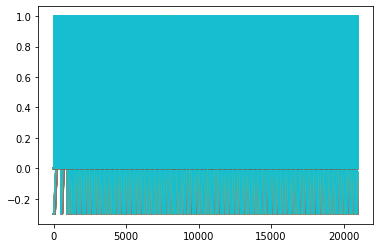

In [30]:
plt.plot(observed[0])

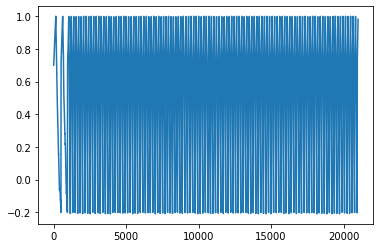

In [31]:
plt.plot(replay_buffer.gather_all().reward.numpy()[0])

In [32]:
dir(agent)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_action_spec',
 '_add_variable_with_custom_getter',
 '_boltzmann_temperature',
 '_check_action_spec',
 '_check_trajectory_dimensions',
 '_checkpoint_dependencies',
 '_collect_policy',
 '_compute_next_q_values',
 '_compute_q_values',
 '_debug_summaries',
 '_deferred_dependencies',
 '_enable_functions',
 '_enable_summaries',
 '_epsilon_greedy',
 '_experience_to_transitions',
 '_flatten',
 '_gamma',
 '_gather_saveables_for_checkpoint',
 '_get_target_updater',
 '_gradient_clipping',
 '_handle_deferred_dependencies',
 '_initialize',
 '_initialize_fn',
 '_list_extra_dependencies_for_serializat